In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
import numpy as np
import lpips
from importlib.machinery import SourceFileLoader
import glob
import cv2

from utils.save import *
from utils.utils import *

In [3]:
from models.ROLE import compute_raindrop
from models.Defence import compute_fence
from models.Dirt import compute_dirt
from train import compute_dirt_raindrop

In [4]:
ckpt_path = 'ckpts/MV_recon/'
args = json.load(open(os.path.join(ckpt_path,'args.json'),'r'))
args = AttributeDict(args)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
param = SourceFileLoader("param", os.path.join(ckpt_path,args.param_file.split('/')[-1])).load_module()
# TODO: update path to the training data in convert_resolution()
param = convert_resolution(param,args)
args.param = param
DOE_phase = torch.load('ckpts/MV_2400_phase.pt', map_location=args.device).detach()

# set DOE_phase to be all zero can simulate conventional capture capture

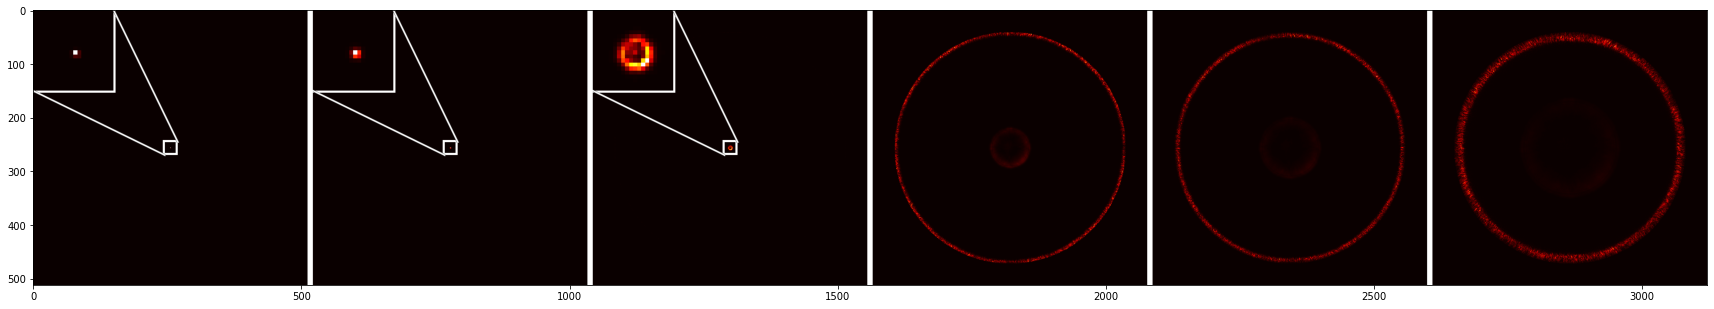

In [5]:
psfs_opt, log_psfs_opt = plot_depth_based_psf(DOE_phase, args, depths = param.plot_depth, wvls = 'design', normalize = False, merge_channel = True)
psfs_opt_viz = plot_psf_array(psfs_opt, param, g=1)

In [6]:
transform_test = transforms.Compose([
        transforms.RandomCrop(param.data_resolution,pad_if_needed=True), # Places365 image size varies
        transforms.CenterCrop(param.equiv_crop_size),
        transforms.Resize([param.img_res, param.img_res]),
        transforms.ToTensor(),
    ])
if args.obstruction == 'fence':
    testset = torchvision.datasets.Places365(
        root=param.dataset_dir, split="val", transform=transform_test)       
else:
    testset = torchvision.datasets.ImageFolder(param.val_dir, transform=transform_test)

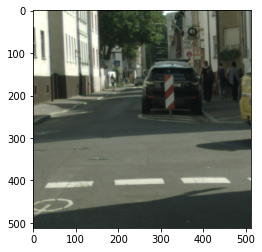

In [7]:
image_far = testset[0][0][None,...].to(args.device)
pyplot.imshow(image_far[0].permute(1,2,0).cpu())

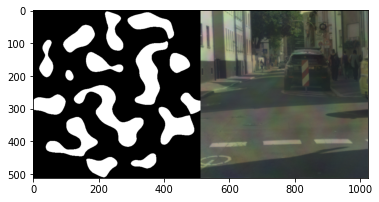

In [8]:
image_near, mask, image_DOE, image_near_DOE, image_far_DOE, psf_near, psf_far, mask_doe, height_map = image_formation(image_far,DOE_phase, compute_dirt, args)
pyplot.imshow(torch.cat([mask, image_DOE],-1)[0].permute(1,2,0).cpu())

In [9]:
from models.recon import Arch
G = Arch(args).to(args.device)
G.load_state_dict(torch.load(last_save(ckpt_path, 'G_*'), map_location=args.device))

<All keys matched successfully>

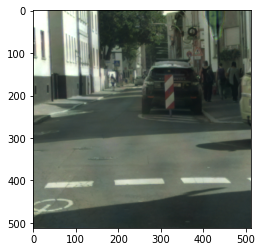

In [10]:
with torch.no_grad(): 
    image_recon = G(image_DOE, psf_near, psf_far)
pyplot.imshow(torch.clamp(image_recon,0,1)[0].permute(1,2,0).cpu())